# Ejercicio 4 – Predicción de serie temporal horaria con Prophet

---

### Paso 1: Preparar el dataset

In [2]:
from prophet import Prophet
import pandas as pd

# Cargar dataset desde archivo CSV
df = pd.read_csv("data/m5_consumo_energia.csv", parse_dates=["dt"])

# Establecer columna temporal como índice
df.set_index("dt", inplace=True)

df.info()

Importing plotly failed. Interactive plots will not work.


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4414 entries, 2024-07-01 00:00:00 to 2024-12-31 23:00:00
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Energia Consumida  4414 non-null   float64
 1   Temperatura        4414 non-null   float64
 2   Humedad            4414 non-null   float64
dtypes: float64(3)
memory usage: 137.9 KB


In [3]:
df.describe()

,Energia Consumida,Temperatura,Humedad
count,4414.000000,4414.000000,4414.000000
mean,8.284391,22.794003,71.333213
std,2.668329,2.401165,12.833494
min,3.780000,12.840000,21.400000
25%,6.392500,21.270000,66.960000
50%,7.470000,22.800000,73.410000
75%,9.617500,24.420000,79.865000
max,17.700000,31.580000,95.610000


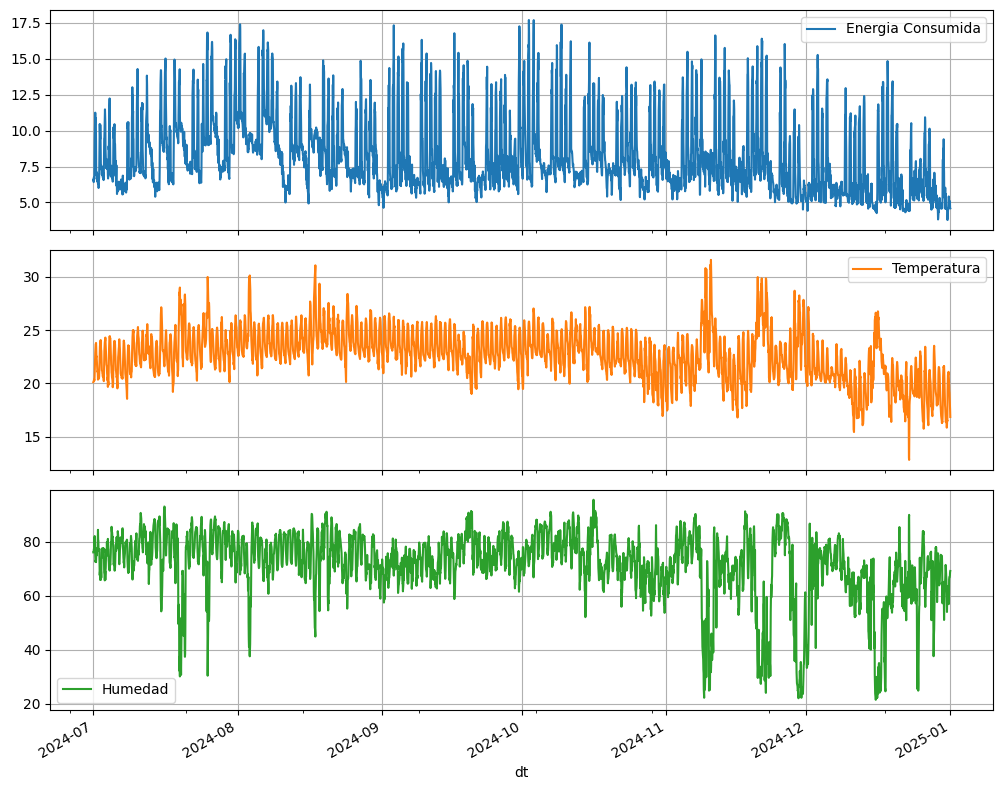

In [4]:
import matplotlib.pyplot as plt
# Visualizar las variables clave
df.plot(subplots=True, figsize=(10, 8), grid=True)
plt.tight_layout()
plt.show()

Seleccionamos solo el mes de Julio para facilitar el análisis

In [5]:
daily_df = df[df.index.month == 7]
daily_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2024-07-01 00:00:00 to 2024-07-31 23:00:00
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Energia Consumida  744 non-null    float64
 1   Temperatura        744 non-null    float64
 2   Humedad            744 non-null    float64
dtypes: float64(3)
memory usage: 23.2 KB


In [6]:
daily_df.describe()

,Energia Consumida,Temperatura,Humedad
count,744.000000,744.000000,744.000000
mean,8.878266,23.071626,76.110605
std,2.443252,1.888542,9.847702
min,5.400000,18.560000,30.070000
25%,7.020000,21.647500,72.567500
50%,8.275000,22.945000,77.600000
75%,10.165000,24.305000,82.200000
max,16.830000,29.980000,93.110000


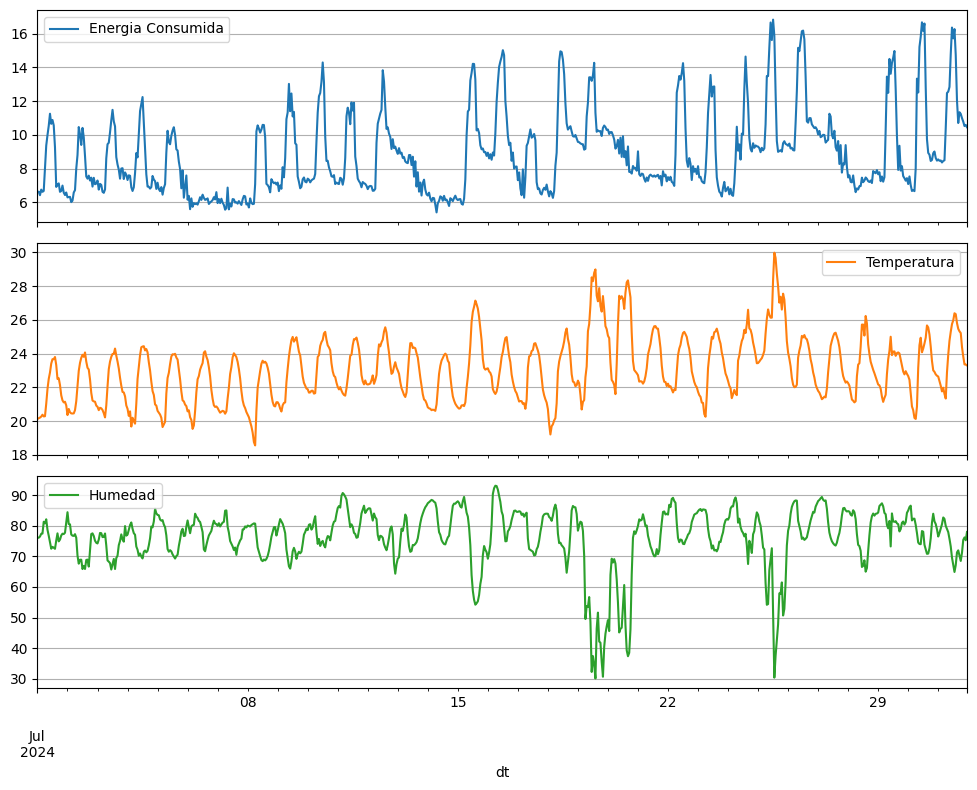

In [7]:
# Visualizar las variables clave
daily_df.plot(subplots=True, figsize=(10, 8), grid=True)
plt.tight_layout()
plt.show()

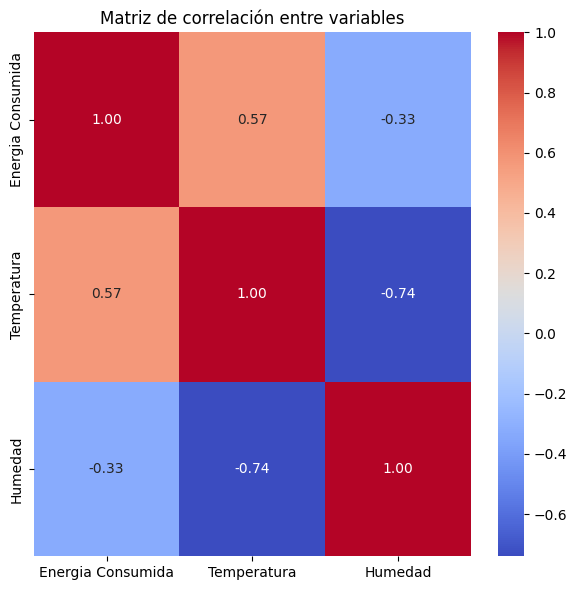

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular matriz de correlación
corr = daily_df.corr()

# Representar heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación entre variables")
plt.tight_layout()
plt.show()

### Paso 2: Separar datos de entrenamiento y validación
Dividimos el dataset en entrenamiento y validación

In [9]:
train_df = daily_df[daily_df.index.day <= 29]
val_df = daily_df[daily_df.index.day > 29]

# Prophet requiere columnas: 'ds' para fecha y 'y' para valor
train_df = train_df.rename(columns={"Energia Consumida": "y"})
val_df = val_df.rename(columns={"Energia Consumida": "y"})

In [10]:
print("Entrenamiento: {} muestras".format(len(train_df)))
print("Validación: {} muestras".format(len(val_df)))

Entrenamiento: 696 muestras
Validación: 48 muestras


### Paso 2: Añadir regresores al dataframe

In [11]:
# Preparar dataset con variables externas (Temperatura y Humedad)
train_reg_df = train_df.reset_index().rename(columns={
    "dt": "ds",
    "Energia Consumida": "y"
})
train_reg_df = train_reg_df[["ds","y"]]

# Añadir regresores
train_reg_df["temperatura"] = train_df["Temperatura"].values
train_reg_df["humedad"] = train_df["Humedad"].values

train_reg_df

,ds,y,temperatura,humedad
0,2024-07-01 00:00:00,6.60,20.13,76.09
1,2024-07-01 01:00:00,6.63,20.17,76.11
2,2024-07-01 02:00:00,6.42,20.21,76.50
3,2024-07-01 03:00:00,6.75,20.27,77.38
4,2024-07-01 04:00:00,6.62,20.38,77.46
...,...,...,...,...
691,2024-07-29 19:00:00,8.14,23.28,80.98
692,2024-07-29 20:00:00,7.55,22.94,81.41
693,2024-07-29 21:00:00,7.43,22.77,80.40
694,2024-07-29 22:00:00,7.28,22.96,81.19


---

### Paso 3: Definir modelo con regresores

In [12]:
model = Prophet()
# model.add_regressor("temperatura")
# model.add_regressor("humedad")

model.fit(train_reg_df)

09:43:54 - cmdstanpy - INFO - Chain [1] start processing
09:43:54 - cmdstanpy - INFO - Chain [1] done processing


---

### Paso 3: Crear futuro con regresores

In [13]:
# Reconstruimos el dataset completo
all_df = pd.concat([train_df, val_df], axis=0)
all_df = all_df.rename({"Temperatura":"temperatura",
                        "Humedad":"humedad",}, axis=1)


In [14]:
# Duplicamos y eliminamos la variable a predecir
future_df = all_df.copy()
future_df = future_df.drop(["y"], axis=1)
future_df['ds'] = future_df.index
future_df

,temperatura,humedad,ds
dt,,,
2024-07-01 00:00:00,20.13,76.09,2024-07-01 00:00:00
2024-07-01 01:00:00,20.17,76.11,2024-07-01 01:00:00
2024-07-01 02:00:00,20.21,76.50,2024-07-01 02:00:00
2024-07-01 03:00:00,20.27,77.38,2024-07-01 03:00:00
2024-07-01 04:00:00,20.38,77.46,2024-07-01 04:00:00
...,...,...,...
2024-07-31 19:00:00,24.39,71.21,2024-07-31 19:00:00
2024-07-31 20:00:00,23.83,75.39,2024-07-31 20:00:00
2024-07-31 21:00:00,23.36,76.21,2024-07-31 21:00:00


---

### Paso 4: Predecir y visualizar

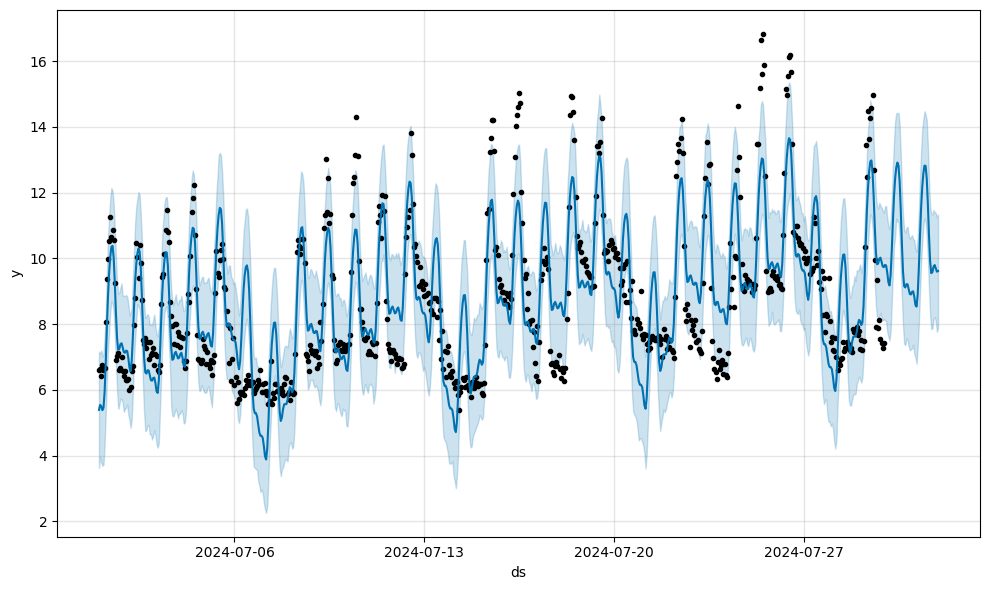

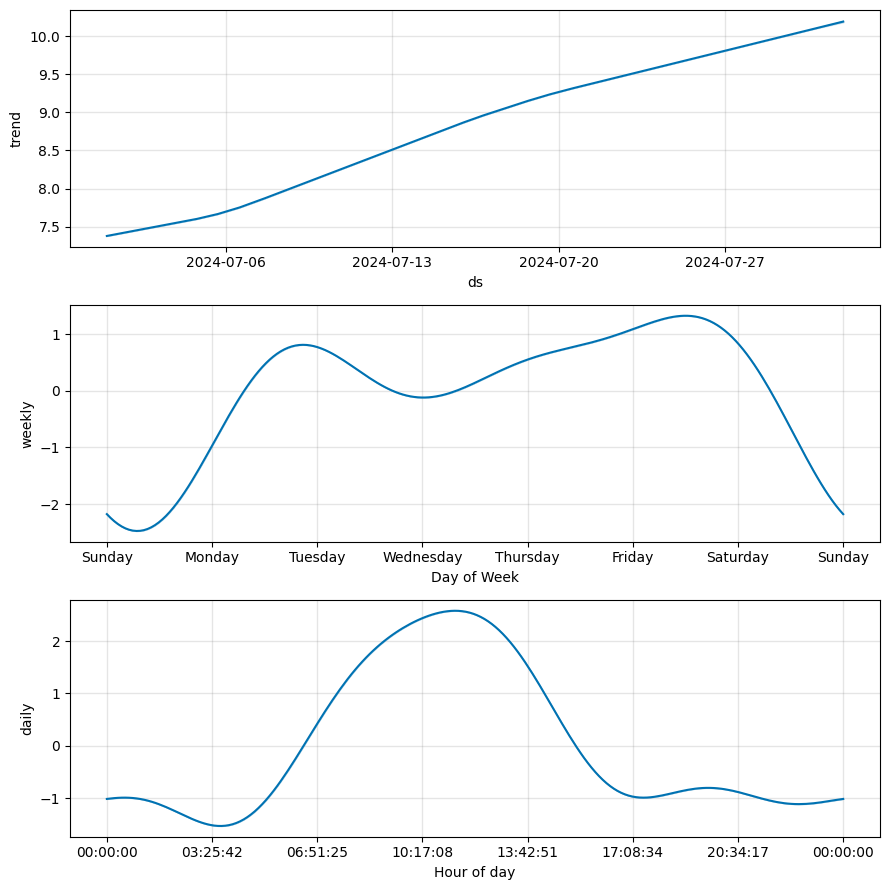

In [15]:
forecast_reg = model.predict(future_df)

# Visualización
fig1 = model.plot(forecast_reg)
fig2 = model.plot_components(forecast_reg)

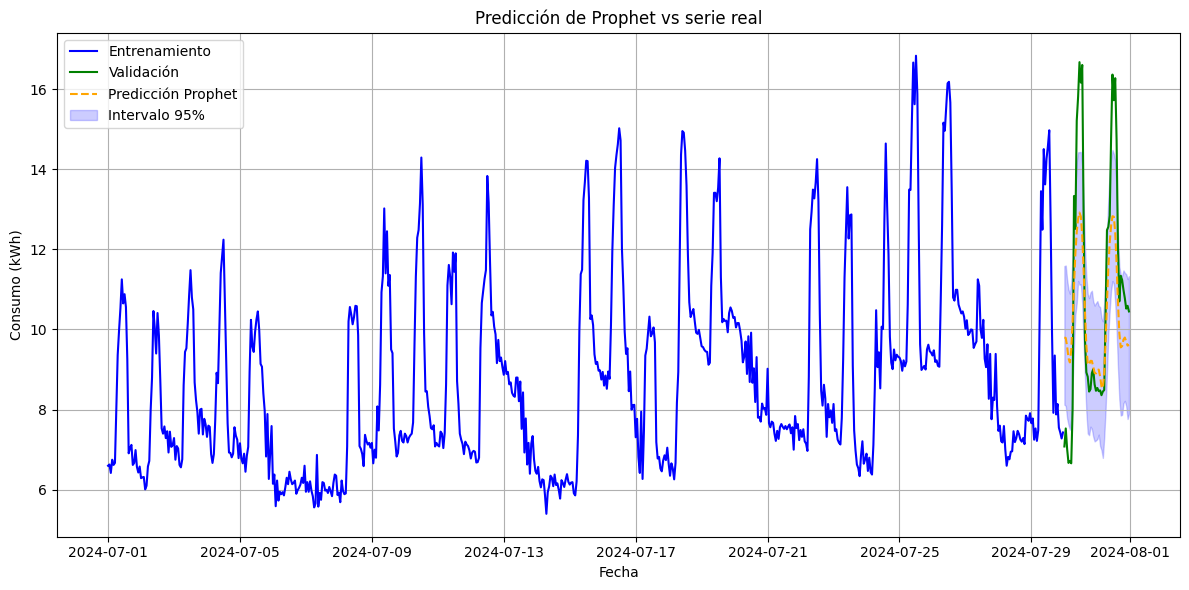

In [16]:
import matplotlib.pyplot as plt

train_df['ds'] = train_df.index
val_df['ds'] = val_df.index
# También puedes obtener el final de train como referencia
cutoff_date = train_df['ds'].max()

# Filtramos la parte futura del forecast
forecast_reg_future = forecast_reg[forecast_reg["ds"] > cutoff_date]

# Graficamos todo
plt.figure(figsize=(12, 6))

# Serie real
plt.plot(train_df["ds"], train_df["y"], label="Entrenamiento", color="blue")
plt.plot(val_df["ds"], val_df["y"], label="Validación", color="green")

# Predicción
plt.plot(forecast_reg_future["ds"], forecast_reg_future["yhat"], label="Predicción Prophet", color="orange", linestyle="--")

# Intervalo de confianza
plt.fill_between(forecast_reg_future["ds"],
                 forecast_reg_future["yhat_lower"],
                 forecast_reg_future["yhat_upper"],
                 color="blue", alpha=0.2, label="Intervalo 95%")

# Formato
plt.title("Predicción de Prophet vs serie real")
plt.xlabel("Fecha")
plt.ylabel("Consumo (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

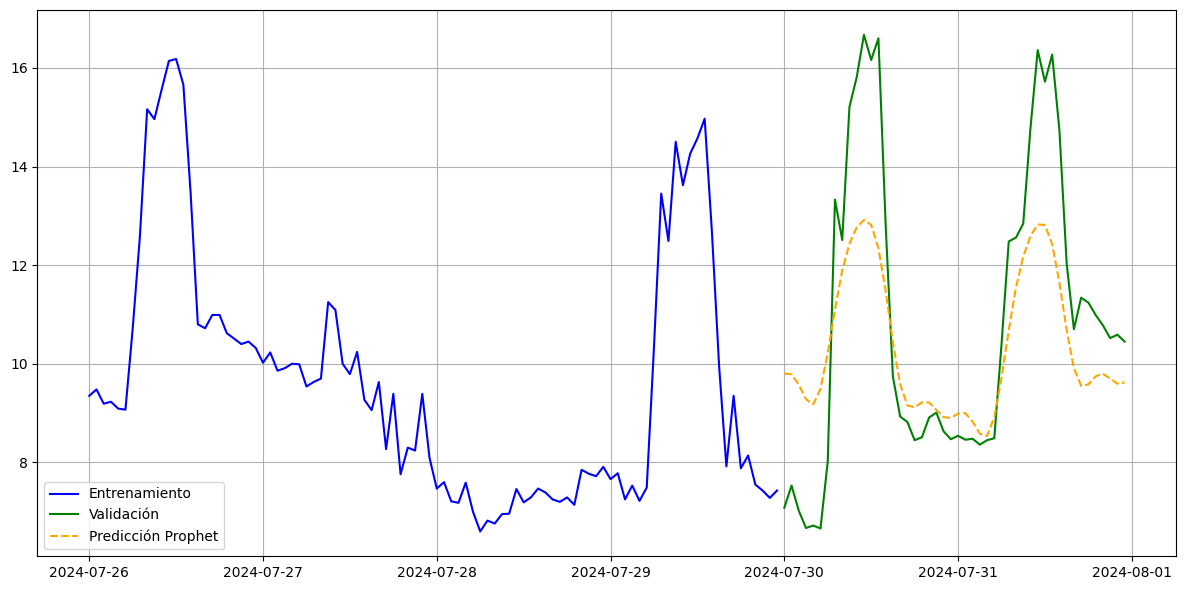

In [17]:
# Graficamos todo
plt.figure(figsize=(12, 6))

# Serie real
plt.plot(train_df[-96:]["ds"], train_df[-96:]["y"], label="Entrenamiento", color="blue")
plt.plot(val_df["ds"], val_df["y"], label="Validación", color="green")

# Predicción
plt.plot(forecast_reg_future["ds"], forecast_reg_future["yhat"], label="Predicción Prophet", color="orange", linestyle="--")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

---

### Paso 5: Evaluar el modelo

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(val_df["y"], forecast_reg_future["yhat"])
rmse = np.sqrt(mean_squared_error(val_df["y"], forecast_reg_future["yhat"]))

print(f"MAE: {mae:.2f}")
#print(f"RMSE: {rmse:.2f}")

MAE: 1.57


---

## ✅ Resultado esperado

- Preparar tus datos en formato adecuado para Prophet.
- Entrenar modelos con y sin regresores externos.
- Visualizar tendencias, estacionalidades y componentes.
- Comparar predicciones y detectar el efecto de variables como temperatura o humedad.